<a href="https://www.bigdatauniversity.com"><img src = "https://ocw.mit.edu/courses/sloan-school-of-management/15-097-prediction-machine-learning-and-statistics-spring-2012/15-097s12.jpg" width = 400, align = "center"></a>

<h1 align=center><font size = 15> Classification Algorithms</font></h1>

In this notebook, we will use different classification algorithms to predict whether a student will pay off their loans on time or default.

We will need the following libraries:

In [94]:
import itertools

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

### About the Dataset

This dataset is about past loans. The __loan_train.csv__ data set includes details of 346 customers whose loans are already paid off or defaulted. It includes the following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |



For this lab, __loan_train.csv__ will be used to train the algorithms.  Later, the __loan_test.csv__ will be used to test how accurate it can predict out of sample values. We will download and initialize them:

### Load Data From CSV File  

In [57]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
df = pd.read_csv('loan_train.csv')
test_df = pd.read_csv('loan_test.csv')

--2018-11-18 22:32:16--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.193
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.002s  

2018-11-18 22:32:16 (14.2 MB/s) - ‘loan_train.csv’ saved [23101/23101]

--2018-11-18 22:32:16--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.193
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.22

# Pre-processing:  Feature selection/extraction

### Converting to Date Time Object 

In [64]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])

### Day of the Week Selection

We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [66]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)

### Converting Categorical Features to Binary Values

#### Gender:

Male = 0
Female = 1


In [11]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)

#### Education:

In [14]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)

Feature_test = test_df[['Principal','terms','age','Gender','weekend']]
Feature_test = pd.concat([Feature_test,pd.get_dummies(test_df['education'])], axis=1)
Feature_test.drop(['Master or Above'], axis = 1,inplace=True)

Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


#### Feature Selection

Defining Feature Sets:

In [15]:
X_train = Feature
X_test = Feature_test

Using the following labels:

In [67]:
y_train = df['loan_status'].values
y_test = test_df['loan_status'].values

#### Normalize Data 

Data Standardization gives data zero mean and unit variance.

In [17]:
X_train= preprocessing.StandardScaler().fit(X_train).transform(X_train)
X_test= preprocessing.StandardScaler().fit(X_test).transform(X_test)

# Classification 

The following algorithms will be used to classify our set. 
- K Nearest Neighbor
- Decision Tree
- Support Vector Machine
- Logistic Regression

Then, we will analyze the accuracy of each classification method.

### K Nearest Neighbor

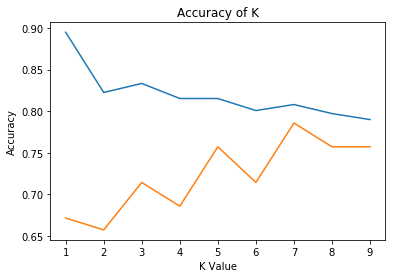

In [89]:
#       --------------------
#      |K NEAREST NEIGHBOR |
#      --------------------

X_train_prek, X_test_prek, y_train_prek, y_test_prek = train_test_split( X_train, y_train, test_size=0.2, random_state=4)
#print ('Train set:', X_train_prek.shape,  y_train_prek.shape)   #To visualize the train set
#print ('Test set:', X_test_prek.shape,  y_test_prek.shape)      #To visualize the test set

###Determining the Most Accurate k
beg=1                             #starting value for the k value to be tested.  Suggested to start at 1
tot= 10                              #iterative k value to be used later.  
train_set_accuracy= np.zeros(tot)  #To be used in storage of iterative values based on k value(tot)
test_set_accuracy= np.zeros(tot)   #To be used in storage of iterative values based on k value(tot)
for i in range(beg,tot):
    k = i
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train_prek,y_train_prek)
    yhat = neigh.predict(X_test_prek)
    train_set_accuracy[i]=metrics.accuracy_score(y_train_prek, neigh.predict(X_train_prek))
    test_set_accuracy[i]=metrics.accuracy_score(y_test_prek, yhat)

#Plot values
plt.plot(range(beg,tot),train_set_accuracy[beg:tot],)
plt.plot(range(beg,tot),test_set_accuracy[beg:tot])
plt.xlabel('K Value')
plt.ylabel('Accuracy')
plt.title('Accuracy of K')
plt.show()

The maximum accuracy is where k=7
Now we will use that value for k and compare our test data without using the split.

NOTE:  K was determined only using the training sample.  This was to promote authenticity because
in a real work application, your testing sample would be its application.

In [85]:
k=7   #The value found above

neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
KNN_yhat = neigh.predict(X_test)

KNN_jaccard=jaccard_similarity_score(y_test, KNN_yhat)
KNN_f1_score=f1_score(y_test, KNN_yhat, average='weighted')

print(KNN_jaccard)
print(KNN_f1_score)

0.722222222222
0.700198920148


### Decision Tree

In [90]:
#       ---------------
#      |Decision Tree |
#      ---------------

drugTree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
drugTree.fit(X_train,y_train)
DT_yhat = drugTree.predict(X_test)

DT_jaccard=jaccard_similarity_score(y_test, DT_yhat)
DT_f1_score=f1_score(y_test, DT_yhat, average='weighted')

print(DT_jaccard)
print(DT_f1_score)

0.777777777778
0.728395061728


### Support Vector Machine

In [91]:
#       -----------------------
#      |Support Vector Machine|
#      -----------------------

svmm = svm.SVC(kernel='rbf')
svmm.fit(X_train, y_train) 
SVM_yhat = svmm.predict(X_test)

SVM_jaccard=jaccard_similarity_score(y_test, SVM_yhat)
SVM_f1_score=f1_score(y_test, SVM_yhat, average='weighted')

print(SVM_jaccard)
print(SVM_f1_score)

0.722222222222
0.621266427718


### Logistic Regression

In [92]:
#       --------------------
#      |Logistic Regression|
#      --------------------

LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
LR_yhat = LR.predict(X_test)
LR_yhat_prob = LR.predict_proba(X_test)

LR_jaccard=jaccard_similarity_score(y_test, LR_yhat)
LR_f1_score=f1_score(y_test, LR_yhat, average='weighted')
LR_logloss=log_loss(y_test, LR_yhat_prob)

print(LR_jaccard)
print(LR_f1_score)
print(LR_logloss)

0.740740740741
0.630417651694
0.556608494631


/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Evaluation Table and Report

In [93]:
data = {'Jaccard':[KNN_jaccard,DT_jaccard,SVM_jaccard,LR_jaccard],
        'F1-Score':[KNN_f1_score,DT_f1_score,SVM_f1_score,LR_f1_score],
       'Log Loss':['?','?','?',LR_logloss]}
eval_table = pd.DataFrame(data, index=['KNN','Decision Tree','SVM','Logistic Regression'])
print (eval_table)

                     F1-Score   Jaccard  Log Loss
KNN                  0.700199  0.722222         ?
Decision Tree        0.728395  0.777778         ?
SVM                  0.621266  0.722222         ?
Logistic Regression  0.630418  0.740741  0.556608
